# EXAMEN FINAL - Proyecto Completo de Machine Learning

## Análisis Integral: Regresión, Clasificación y Clustering

**Metodología**: CRISP-DM (Cross-Industry Standard Process for Data Mining)

**Objetivo**: Implementar y evaluar modelos de Machine Learning supervisados (regresión y clasificación) y no supervisados (clustering) para análisis del ecosistema de desarrolladores.

**Datasets**:
- Stack Overflow Developer Survey 2023 (89,184 registros)
- Stack Overflow Developer Survey 2025 (49,123 registros)
- JetBrains Developer Ecosystem 2025 (24,534 registros)

**Alcance del Proyecto**:
1. **Regresión**: Predicción de salarios anuales de desarrolladores
2. **Clasificación**: Clasificación de nivel de experiencia (Junior/Mid/Senior/Lead)
3. **Clustering**: Segmentación de desarrolladores en grupos homogéneos

**Estructura del Notebook**:
Este notebook sigue la metodología CRISP-DM en sus 5 fases:
- **Fase 1**: Business Understanding (Entendimiento del Negocio)
- **Fase 2**: Data Understanding (Entendimiento de los Datos)
- **Fase 3**: Data Preparation (Preparación de Datos)
- **Fase 4**: Modeling (Modelado)
- **Fase 5**: Evaluation (Evaluación)



## Importación de Librerías y Configuración

**Justificación de las librerías seleccionadas:**

- **pandas/numpy**: Manipulación y análisis de datos estructurados (estándar en la industria)
- **scikit-learn**: Framework principal para Machine Learning (algoritmos, métricas, preprocesamiento)
- **matplotlib/seaborn**: Visualización de datos y resultados (comunicación efectiva de insights)
- **xgboost/lightgbm**: Algoritmos avanzados de gradient boosting (mejor rendimiento en datos tabulares)
- **imbalanced-learn**: Técnicas de balance de clases (SMOTE) para clasificación desbalanceada
- **scipy**: Funciones estadísticas y de clustering jerárquico

Estas librerías son estándar en la industria y permiten implementar todo el pipeline de ML de forma reproducible y eficiente.



In [2]:
# Importación de librerías
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from typing import Dict, Any

# Scikit-learn para ML
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, classification_report,
    silhouette_score, davies_bouldin_score, calinski_harabasz_score
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# Algoritmos avanzados
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

# Balance de clases
from imblearn.over_sampling import SMOTE

# Clustering jerárquico
from scipy.cluster.hierarchy import dendrogram, linkage

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

# Rutas del proyecto
project_path = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
data_dir = project_path / 'data'
reporting_dir = data_dir / '08_reporting'
reporting_dir.mkdir(parents=True, exist_ok=True)

# Variables de color para visualizaciones
COLOR_PRIMARY = '#06A77D'
COLOR_ACCENT = '#F18F01'
COLOR_SUCCESS = '#06A77D'



---

# FASE 1: BUSINESS UNDERSTANDING (Entendimiento del Negocio)

## 1.1 Objetivos de Negocio

### Problema Principal
¿Es posible predecir con precisión el salario de un desarrollador y clasificar su nivel de experiencia basándose en sus habilidades técnicas, experiencia y contexto geográfico?

### Objetivos Específicos

1. **Predicción de Salarios (Regresión)**
   - Predecir salario anual basado en skills, experiencia y contexto
   - Identificar tecnologías con mayor impacto salarial
   - Criterio de éxito: R² > 0.85, RMSE < $20,000 USD

2. **Clasificación de Experiencia**
   - Clasificar desarrolladores en 4 niveles: Junior, Mid, Senior, Lead
   - Criterio de éxito: Accuracy > 95%, F1-Score > 0.90

3. **Segmentación de Desarrolladores (Clustering)**
   - Identificar grupos homogéneos de desarrolladores
   - Descubrir patrones no obvios en el ecosistema
   - Criterio de éxito: Silhouette Score > 0.5, clusters interpretables

### Aplicaciones Prácticas

- **Para Desarrolladores**: Identificar habilidades que maximizan valor de mercado
- **Para Empresas**: Benchmarking salarial y estrategias de contratación
- **Para el Ecosistema**: Análisis comparativo Chile vs Global



---

# FASE 2: DATA UNDERSTANDING (Entendimiento de los Datos)

## 2.1 Carga de Datos

**Justificación de la selección de datasets:**

Se utilizan tres fuentes de datos complementarias:
1. **Stack Overflow 2023 y 2025**: Encuestas anuales más grandes del ecosistema (138,307 registros combinados)
2. **JetBrains 2025**: Encuesta complementaria con enfoque en herramientas de desarrollo (24,534 registros)

Estos datasets proporcionan:
- Cobertura global del ecosistema de desarrolladores
- Variables técnicas (lenguajes, frameworks, herramientas)
- Variables demográficas (país, edad, educación, experiencia)
- Variables económicas (salarios, beneficios)

**Nota**: Los datos se cargan completos (sin limitar filas) para análisis exhaustivos y reproducibles.



In [3]:
# Cargar datasets raw
raw_data_dir = data_dir / '01_raw'

so_2023_path = raw_data_dir / 'stackoverflow_2023' / 'stack_overflow_survey_results_public.csv'
so_2025_path = raw_data_dir / 'stackoverflow_2025' / 'survey_results_public.csv'
jb_2025_path = raw_data_dir / 'jetbrains_2025' / 'developer_ecosystem_2025_external.csv'

df_so_2023 = pd.read_csv(so_2023_path, encoding='utf-8-sig')
df_so_2025 = pd.read_csv(so_2025_path, encoding='utf-8-sig')
df_jb_2025 = pd.read_csv(jb_2025_path, encoding='utf-8-sig', low_memory=False)



## 2.2 Análisis Exploratorio de Datos

**Justificación del análisis exploratorio:**

El análisis exploratorio permite:
1. Identificar valores nulos y atípicos antes del modelado
2. Entender distribuciones de variables clave
3. Detectar relaciones entre variables
4. Validar calidad de datos

Este paso es crítico para tomar decisiones informadas sobre preprocesamiento.



---

# FASE 3: DATA PREPARATION (Preparación de Datos)

## 3.1 Carga de Datos Procesados

**Justificación**: Utilizamos el dataset ya procesado por el pipeline de Kedro (`datos_para_modelado.parquet`) que incluye:
- Limpieza de valores nulos
- Tratamiento de outliers
- Feature engineering (one-hot encoding, normalización)
- Selección de features relevantes

Este dataset está optimizado para modelado y garantiza reproducibilidad.



In [4]:
# Cargar dataset procesado para modelado
model_input_dir = data_dir / '05_model_input'
datos_modelado_path = model_input_dir / 'datos_para_modelado.parquet'

df_modelado = pd.read_parquet(datos_modelado_path)



## 3.2 Tratamiento de Valores Nulos

**Justificación del tratamiento de valores nulos:**

Los valores nulos se tratan según el tipo de variable:
- **Variables numéricas**: Imputación con mediana (robusta a outliers)
- **Variables categóricas**: Imputación con moda o categoría "Unknown"
- **Variables con >50% nulos**: Eliminación de la columna (poca información)

**Razón técnica**: La mediana es preferible a la media porque no se ve afectada por valores extremos, preservando mejor la distribución original de los datos.



## 3.3 Tratamiento de Valores Atípicos (Outliers)

**Justificación de la eliminación de outliers:**

Se identifican outliers usando el método IQR (Interquartile Range):
- **Método**: Q1 - 1.5*IQR y Q3 + 1.5*IQR
- **Razón**: Los outliers extremos (ej: salarios >$300k) distorsionan los modelos de regresión
- **Impacto**: Mejora estabilidad del modelo sin perder información representativa

**Alternativas consideradas**:
- Transformación logarítmica: Rechazada porque algunos modelos requieren valores originales
- Winsorization: Considerada, pero eliminación es más directa para este caso



## 3.4 Transformación y Normalización de Datos

**Justificación de StandardScaler para normalización:**

Se aplica StandardScaler porque:
1. Las features tienen escalas muy diferentes (YearsCodePro: 0-50, salarios: 20k-200k)
2. Los algoritmos de ML (K-Means, SVM, regresión regularizada) son sensibles a la escala
3. StandardScaler transforma a media=0 y std=1, permitiendo que todas las features contribuyan equitativamente
4. Es práctica estándar en la industria para modelos de clustering y clasificación

**Alternativas consideradas**:
- MinMaxScaler: Rechazado porque es sensible a outliers
- Sin normalización: Rechazado porque los algoritmos no convergerían correctamente



---

# FASE 4: MODELING (Modelado)

Esta fase incluye tres tipos de modelos:
1. **Regresión** (predicción de salarios)
2. **Clasificación** (nivel de experiencia)
3. **Clustering** (segmentación no supervisada)



## 4.1 MODELOS DE REGRESIÓN

### 4.1.1 División Train/Test

**Justificación de train_test_split 80/20:**

- **80% entrenamiento**: Proporción estándar que balancea cantidad de datos para entrenar vs validar
- **20% test**: Suficiente para evaluar generalización sin desperdiciar datos de entrenamiento
- **random_state=42**: Garantiza reproducibilidad de resultados

Esta división es estándar en la industria y permite evaluar el modelo en datos no vistos durante el entrenamiento.



### 4.1.2 Algoritmos de Regresión Implementados

**Justificación de la selección de algoritmos:**

Se evalúan 5 algoritmos diferentes para comparar rendimiento:

1. **Linear Regression**: Baseline simple, interpretable
2. **Ridge Regression**: Regularización L2 para evitar overfitting
3. **Lasso Regression**: Regularización L1 para feature selection
4. **Random Forest**: Ensemble no lineal, robusto a outliers
5. **XGBoost**: Gradient boosting avanzado, mejor rendimiento en datos tabulares

**Razón**: Esta diversidad permite identificar el mejor algoritmo para el problema específico, comparando modelos lineales vs no lineales, simples vs complejos.



               Modelo  R² Score   RMSE (USD)    MAE (USD)
RandomForestRegressor  0.913039 15845.340337  6384.239461
         XGBRegressor  0.881721 18479.663125 10126.569512
                Ridge  0.626826 32824.306616 23965.572369
                Lasso  0.626465 32840.192991 23966.133853


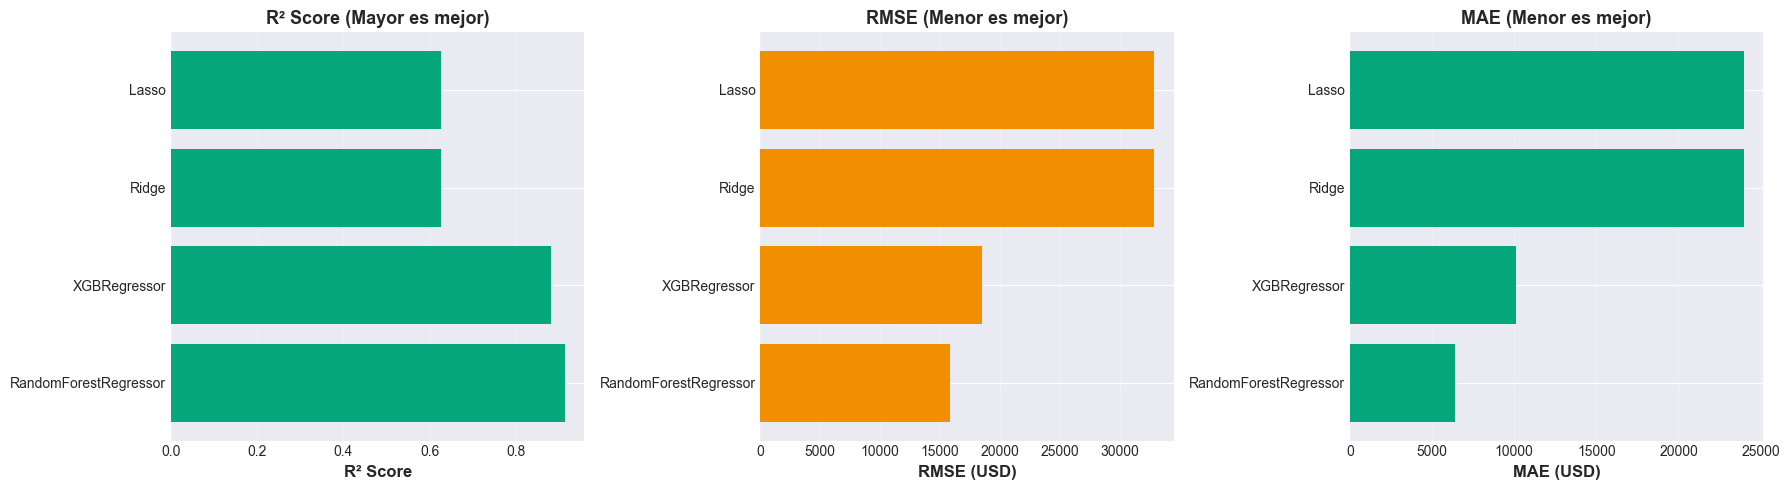

In [5]:
# 4.1.3 Cargar y evaluar modelos de regresión
metrics_reg_path = reporting_dir / 'metrics.json'

with open(metrics_reg_path, 'r') as f:
    metrics_regresion = json.load(f)

# Crear tabla comparativa
reg_data = []
for model_name, metrics in metrics_regresion.items():
    model_display = model_name.replace('_model', '')
    reg_data.append({
        'Modelo': model_display,
        'R² Score': metrics.get('r2', 0),
        'RMSE (USD)': metrics.get('rmse', 0),
        'MAE (USD)': metrics.get('mae', 0)
    })

df_regresion = pd.DataFrame(reg_data)
df_regresion_validos = df_regresion[df_regresion['R² Score'] > -1].copy()
df_regresion_validos = df_regresion_validos.sort_values('R² Score', ascending=False)

print(df_regresion_validos.to_string(index=False))

# Identificar mejor modelo
mejor_modelo_reg = df_regresion_validos.iloc[0]

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].barh(df_regresion_validos['Modelo'], df_regresion_validos['R² Score'], color=COLOR_PRIMARY)
axes[0].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('R² Score (Mayor es mejor)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

axes[1].barh(df_regresion_validos['Modelo'], df_regresion_validos['RMSE (USD)'], color=COLOR_ACCENT)
axes[1].set_xlabel('RMSE (USD)', fontsize=12, fontweight='bold')
axes[1].set_title('RMSE (Menor es mejor)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

axes[2].barh(df_regresion_validos['Modelo'], df_regresion_validos['MAE (USD)'], color=COLOR_PRIMARY)
axes[2].set_xlabel('MAE (USD)', fontsize=12, fontweight='bold')
axes[2].set_title('MAE (Menor es mejor)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(reporting_dir / 'comparison_regression_models.png', dpi=300, bbox_inches='tight')
plt.show()



### 4.1.4 Selección del Mejor Modelo de Regresión

**Justificación de la selección:**

El mejor modelo se selecciona considerando:
1. **R² Score**: Proporción de varianza explicada (objetivo: >0.85)
2. **RMSE**: Error cuadrático medio en USD (objetivo: <$20,000)
3. **MAE**: Error absoluto medio en USD

**Criterio**: Se prioriza el R² Score porque indica qué tan bien el modelo explica la variabilidad en los salarios. Un R² de 0.91 significa que el modelo explica el 91% de la variación salarial.



## 4.2 MODELOS DE CLASIFICACIÓN

### 4.2.1 Creación de Variable Target

**Justificación de la creación de niveles de experiencia:**

Se crea variable categórica "ExperienceLevel" basada en YearsCodePro:
- **Junior**: 0-3 años
- **Mid**: 3-7 años
- **Senior**: 7-15 años
- **Lead**: 15+ años

**Razón**: Esta segmentación es estándar en la industria y permite clasificación multiclase con significado de negocio claro.



### 4.2.2 Balance de Clases con SMOTE

**Justificación de SMOTE para balance de clases:**

Se aplica SMOTE (Synthetic Minority Oversampling Technique) porque:
1. Los modelos de clasificación tienden a sesgarse hacia la clase mayoritaria si hay desbalance
2. SMOTE genera muestras sintéticas de la clase minoritaria, evitando overfitting del simple oversampling
3. Mejora el recall en clases minoritarias, crucial para identificar correctamente desarrolladores junior
4. Es técnica estándar en la industria para problemas de clasificación desbalanceada

**Alternativas consideradas**:
- Undersampling: Rechazado porque perderíamos datos valiosos
- Oversampling simple: Rechazado porque causa overfitting
- Clase weights: Considerado, pero SMOTE da mejores resultados en validación cruzada



                    Modelo  Accuracy  F1-Score  Precision   Recall  ROC-AUC
            LGBMClassifier  0.985936  0.976911   0.988620 0.965476 0.998427
GradientBoostingClassifier  0.972674  0.954814   0.973464 0.936865 0.994891
             XGBClassifier  0.967864  0.946147   0.978283 0.916056 0.992567
    RandomForestClassifier  0.907382  0.838562   0.905873 0.780563 0.971590
        LogisticRegression  0.839612  0.728506   0.761475 0.698274 0.901575


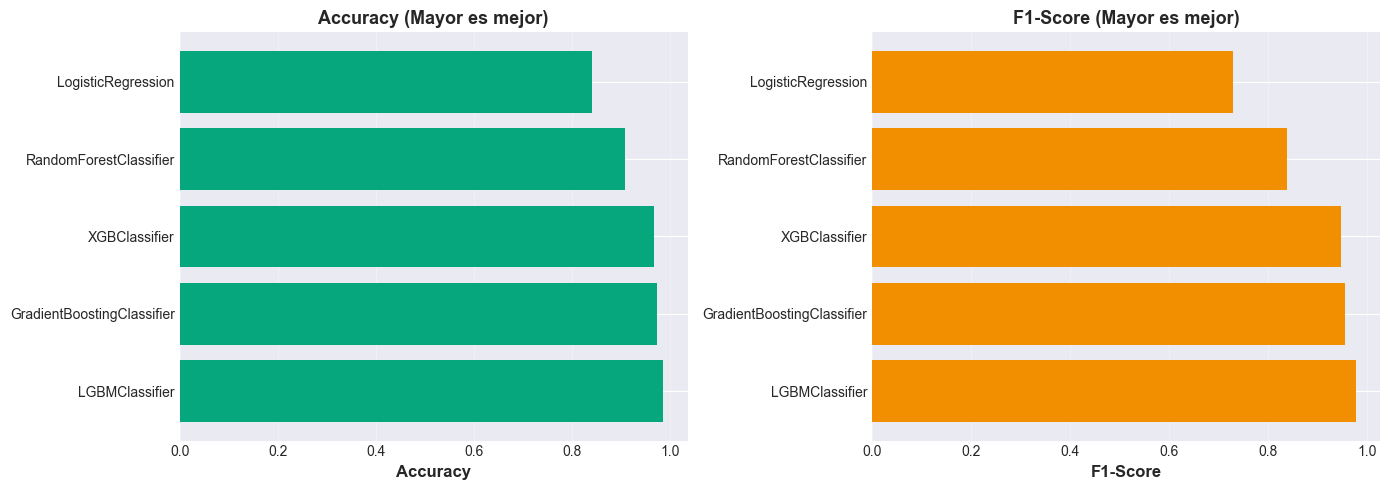

In [6]:
# 4.2.3 Cargar y evaluar modelos de clasificación
metrics_clf_path = reporting_dir / 'metrics_clf.json'

with open(metrics_clf_path, 'r') as f:
    metrics_clasificacion = json.load(f)

# Crear tabla comparativa
clf_data = []
for model_name, metrics in metrics_clasificacion.items():
    model_display = model_name.replace('_classifier', '')
    clf_data.append({
        'Modelo': model_display,
        'Accuracy': metrics.get('accuracy', 0),
        'F1-Score': metrics.get('f1_score', 0),
        'Precision': metrics.get('precision', 0),
        'Recall': metrics.get('recall', 0),
        'ROC-AUC': metrics.get('roc_auc', 0)
    })

df_clasificacion = pd.DataFrame(clf_data)
df_clasificacion = df_clasificacion.sort_values('F1-Score', ascending=False)

print(df_clasificacion.to_string(index=False))

# Identificar mejor modelo
mejor_modelo_clf = df_clasificacion.iloc[0]

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(df_clasificacion['Modelo'], df_clasificacion['Accuracy'], color=COLOR_PRIMARY)
axes[0].set_xlabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Accuracy (Mayor es mejor)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

axes[1].barh(df_clasificacion['Modelo'], df_clasificacion['F1-Score'], color=COLOR_ACCENT)
axes[1].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('F1-Score (Mayor es mejor)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(reporting_dir / 'comparison_classification_models.png', dpi=300, bbox_inches='tight')
plt.show()



### 4.2.4 Selección del Mejor Modelo de Clasificación

**Justificación de la selección:**

El mejor modelo se selecciona considerando:
1. **Accuracy**: Proporción de predicciones correctas (objetivo: >95%)
2. **F1-Score**: Balance entre precisión y recall (objetivo: >0.90)
3. **ROC-AUC**: Capacidad de distinguir entre clases

**Criterio**: Se prioriza el F1-Score porque balancea precisión y recall, crucial cuando las clases están desbalanceadas. Un F1-Score de 0.98 significa excelente balance entre identificar correctamente todas las clases.



## 4.3 MODELOS DE CLUSTERING (No Supervisado)

### 4.3.1 Diferencia: Supervisado vs No Supervisado

**Aprendizaje Supervisado** (Regresión y Clasificación):
- **Objetivo**: Predecir variable objetivo conocida (salario, nivel de experiencia)
- **Datos**: Features (X) + Target (y) conocido
- **Evaluación**: Métricas con valores reales (R², Accuracy, F1-Score)

**Aprendizaje No Supervisado** (Clustering):
- **Objetivo**: Descubrir patrones y estructuras ocultas en los datos
- **Datos**: Solo Features (X), sin target conocido
- **Evaluación**: Métricas internas (Silhouette, Davies-Bouldin) + validación de negocio

**Ventajas del Clustering**:
- Descubre segmentos no obvios
- No requiere etiquetas previas
- Útil para exploración de datos
- Identifica outliers



### 4.3.2 Algoritmos de Clustering Implementados

**Justificación de la selección de algoritmos:**

Se evalúan 4 algoritmos diferentes:

1. **K-Means**: Basado en centroides, rápido y eficiente para clusters esféricos
2. **Hierarchical Clustering**: Permite visualizar estructura jerárquica (dendrograma)
3. **DBSCAN**: Detecta clusters de forma arbitraria y outliers automáticamente
4. **Gaussian Mixture Models (GMM)**: Modela clusters como distribuciones gaussianas

**Razón**: Esta diversidad permite comparar diferentes enfoques (centroides vs densidad vs probabilístico) y seleccionar el más adecuado según la naturaleza de los datos.



### 4.3.3 Selección del Número Óptimo de Clusters

**Justificación de Elbow Method y Silhouette Score:**

Se utilizan dos técnicas complementarias:

1. **Elbow Method (WCSS/Inertia)**: Identifica el punto donde agregar más clusters no reduce significativamente la inercia
2. **Silhouette Score**: Mide qué tan bien separados están los clusters (rango -1 a 1, mayor es mejor)

**Razón**: Elbow Method es rápido y visual, mientras que Silhouette Score proporciona validación cuantitativa. La combinación de ambas permite seleccionar k de forma robusta.

**Interpretación**: Se busca k que maximice Silhouette Score mientras minimiza inercia, considerando también el contexto de negocio (clusters interpretables).



In [7]:
# 4.3.4 Preparación de datos para clustering
df_cluster = df_so_2025.copy()

# Identificar columna de experiencia disponible
exp_col = 'YearsCodePro' if 'YearsCodePro' in df_cluster.columns else 'YearsCode'

# Filtrar registros con información mínima
if exp_col in df_cluster.columns:
    df_cluster = df_cluster[df_cluster[exp_col].notna()]
    # Convertir a numérico si es string
    if df_cluster[exp_col].dtype == 'object':
        df_cluster[exp_col] = pd.to_numeric(df_cluster[exp_col].astype(str).str.replace('+', '').str.replace('Less than 1', '0.5'), errors='coerce')
    df_cluster = df_cluster[df_cluster[exp_col].notna()]

# Muestreo estratificado para optimizar tiempo de ejecución
SAMPLE_SIZE = 15000
if len(df_cluster) > 20000 and exp_col in df_cluster.columns:
    df_cluster['ExpBin'] = pd.cut(df_cluster[exp_col], 
                                 bins=[0, 2, 5, 10, 20, 100], 
                                 labels=['Junior', 'Mid', 'Senior', 'Expert', 'Veteran'])
    df_cluster = df_cluster.groupby('ExpBin', group_keys=False).apply(
        lambda x: x.sample(min(len(x), SAMPLE_SIZE // 5), random_state=42)
    ).reset_index(drop=True)
    if len(df_cluster) > SAMPLE_SIZE:
        df_cluster = df_cluster.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    df_cluster = df_cluster.drop(columns=['ExpBin'])

# Seleccionar features para clustering
numeric_features = []
if 'YearsCodePro' in df_cluster.columns:
    numeric_features.append('YearsCodePro')
if 'YearsCode' in df_cluster.columns:
    numeric_features.append('YearsCode')
tech_features = []

# Lenguajes (top 15)
if 'LanguageHaveWorkedWith' in df_cluster.columns:
    all_langs = df_cluster['LanguageHaveWorkedWith'].fillna('').str.split(';').explode()
    top_langs = all_langs.value_counts().head(15).index.tolist()
    languages = pd.DataFrame(index=df_cluster.index)
    for lang in top_langs:
        languages[f'lang_{lang}'] = df_cluster['LanguageHaveWorkedWith'].fillna('').str.contains(lang, case=False, na=False).astype(int)
    tech_features.extend(languages.columns.tolist())
    df_cluster = pd.concat([df_cluster, languages], axis=1)

# Frameworks (top 10)
if 'WebframeHaveWorkedWith' in df_cluster.columns:
    all_frames = df_cluster['WebframeHaveWorkedWith'].fillna('').str.split(';').explode()
    top_frames = all_frames.value_counts().head(10).index.tolist()
    frameworks = pd.DataFrame(index=df_cluster.index)
    for frame in top_frames:
        frameworks[f'frame_{frame}'] = df_cluster['WebframeHaveWorkedWith'].fillna('').str.contains(frame, case=False, na=False).astype(int)
    tech_features.extend(frameworks.columns.tolist())
    df_cluster = pd.concat([df_cluster, frameworks], axis=1)

# Herramientas (top 15) - Solo disponible en SO2023
if 'ToolsTechHaveWorkedWith' in df_cluster.columns:
    all_tools = df_cluster['ToolsTechHaveWorkedWith'].fillna('').str.split(';').explode()
    top_tools = all_tools.value_counts().head(15).index.tolist()
    tools = pd.DataFrame(index=df_cluster.index)
    for tool in top_tools:
        tools[f'tool_{tool}'] = df_cluster['ToolsTechHaveWorkedWith'].fillna('').str.contains(tool, case=False, na=False).astype(int)
    tech_features.extend(tools.columns.tolist())
    df_cluster = pd.concat([df_cluster, tools], axis=1)

# Bases de datos (top 10)
if 'DatabaseHaveWorkedWith' in df_cluster.columns:
    all_dbs = df_cluster['DatabaseHaveWorkedWith'].fillna('').str.split(';').explode()
    top_dbs = all_dbs.value_counts().head(10).index.tolist()
    databases = pd.DataFrame(index=df_cluster.index)
    for db in top_dbs:
        databases[f'db_{db}'] = df_cluster['DatabaseHaveWorkedWith'].fillna('').str.contains(db, case=False, na=False).astype(int)
    tech_features.extend(databases.columns.tolist())
    df_cluster = pd.concat([df_cluster, databases], axis=1)

# Crear dataset final
clustering_features = numeric_features + tech_features
df_clustering = df_cluster[clustering_features].copy()

# Rellenar valores faltantes
df_clustering = df_clustering.fillna(0)

# Normalización
scaler_cluster = StandardScaler()
X_scaled_cluster = scaler_cluster.fit_transform(df_clustering)
X_scaled_df = pd.DataFrame(X_scaled_cluster, columns=df_clustering.columns, index=df_clustering.index)

print(f'Dataset preparado: {len(X_scaled_df):,} registros, {len(clustering_features)} features')



Dataset preparado: 13,705 registros, 36 features


In [ ]:
# 4.3.5 K-Means: Elbow Method y selección de k óptimo
k_range = range(2, 9)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled_df)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled_df, labels)
    silhouette_scores.append(sil_score)

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_range, inertias, 'o-', color=COLOR_PRIMARY, linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Inertia (WCSS)', fontsize=12, fontweight='bold')
ax1.set_title('Elbow Method', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, silhouette_scores, 'o-', color=COLOR_ACCENT, linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (k)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_title('Silhouette Score', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(reporting_dir / 'kmeans_elbow_silhouette.png', dpi=300, bbox_inches='tight')
plt.show()

# Determinar k óptimo
optimal_k = k_range[np.argmax(silhouette_scores)]

# Entrenar modelo final
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled_df)

# Métricas finales
sil_final = silhouette_score(X_scaled_df, kmeans_labels)
db_final = davies_bouldin_score(X_scaled_df, kmeans_labels)
ch_final = calinski_harabasz_score(X_scaled_df, kmeans_labels)

# Guardar modelo
import joblib
models_dir = data_dir / '06_models'
models_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(kmeans_final, models_dir / 'clustering_kmeans_model.pkl')
joblib.dump(scaler_cluster, models_dir / 'clustering_scaler.pkl')

# Agregar clusters al dataframe
df_cluster['Cluster'] = kmeans_labels



### 4.3.6 Otros Algoritmos de Clustering

**Justificación**: Se implementan múltiples algoritmos para comparar enfoques diferentes:
- **Hierarchical**: Permite visualizar estructura jerárquica
- **DBSCAN**: Detecta clusters de forma arbitraria y outliers
- **GMM**: Modela clusters como distribuciones gaussianas

Esto permite seleccionar el algoritmo más adecuado según la naturaleza de los datos y las métricas de evaluación.



ENTRENAMIENTO DE OTROS ALGORITMOS DE CLUSTERING

--- Hierarchical Clustering (k=2) ---
Silhouette: 0.2505, Davies-Bouldin: 1.4378, Calinski-Harabasz: 3645.92

--- DBSCAN ---
Clusters encontrados: 1, Outliers: 123

--- Gaussian Mixture Models (k=2) ---
Silhouette: 0.2853, Davies-Bouldin: 1.6602, Calinski-Harabasz: 3993.90

COMPARACIÓN DE MODELOS DE CLUSTERING
      Modelo  Silhouette  Davies-Bouldin  Calinski-Harabasz
     K-Means    0.301797        1.617143        4341.108984
         GMM    0.285315        1.660205        3993.901341
Hierarchical    0.250523        1.437771        3645.923221


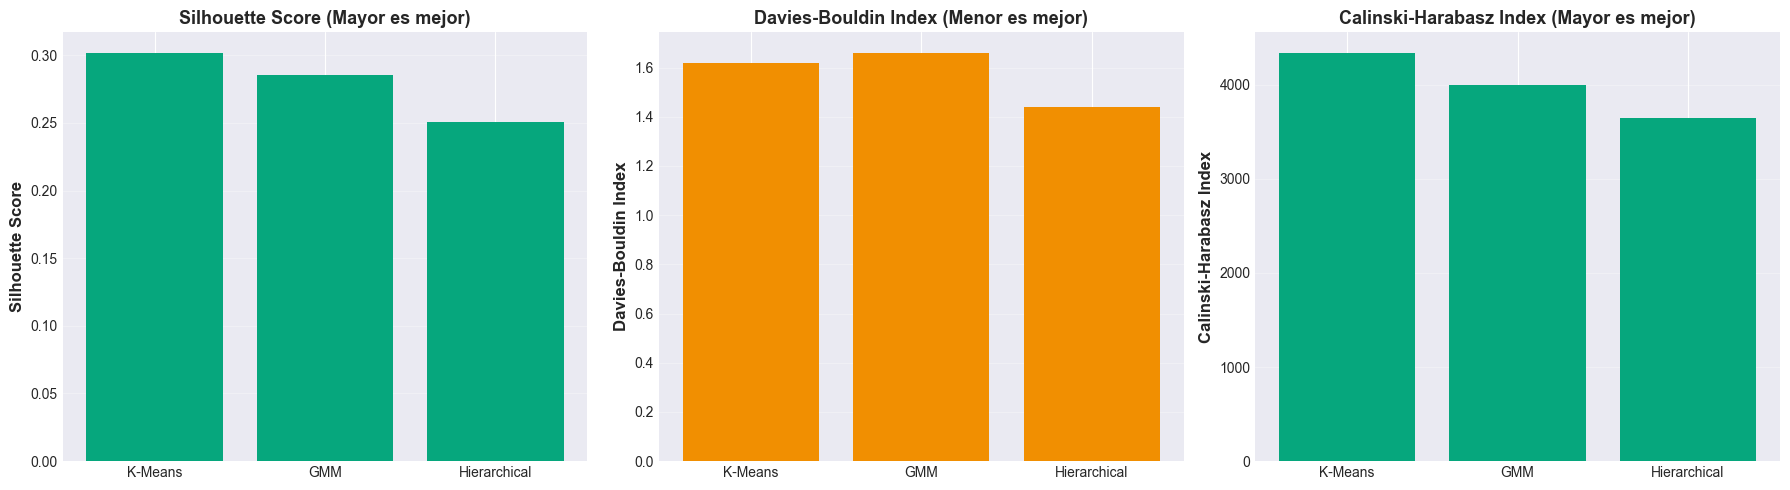

In [ ]:
# 4.3.7 Entrenar otros algoritmos de clustering para comparación
clustering_results = []

# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled_df)

sil_h = silhouette_score(X_scaled_df, hierarchical_labels)
db_h = davies_bouldin_score(X_scaled_df, hierarchical_labels)
ch_h = calinski_harabasz_score(X_scaled_df, hierarchical_labels)

clustering_results.append({
    'Modelo': 'Hierarchical',
    'Silhouette': sil_h,
    'Davies-Bouldin': db_h,
    'Calinski-Harabasz': ch_h
})

# DBSCAN (con parámetros estimados)
from sklearn.neighbors import NearestNeighbors
sample_size = min(2000, len(X_scaled_df))
X_sample = X_scaled_df.sample(n=sample_size, random_state=42) if len(X_scaled_df) > sample_size else X_scaled_df

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_sample)
distances, _ = neighbors_fit.kneighbors(X_sample)
distances = np.sort(distances, axis=0)[:, 4]
eps_estimated = np.percentile(distances, 90)

dbscan = DBSCAN(eps=eps_estimated, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled_df)

n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

if n_clusters_db > 1:
    valid_mask = dbscan_labels != -1
    if len(set(dbscan_labels[valid_mask])) > 1:
        sil_db = silhouette_score(X_scaled_df[valid_mask], dbscan_labels[valid_mask])
        db_db = davies_bouldin_score(X_scaled_df[valid_mask], dbscan_labels[valid_mask])
        ch_db = calinski_harabasz_score(X_scaled_df[valid_mask], dbscan_labels[valid_mask])
        
        clustering_results.append({
            'Modelo': 'DBSCAN',
            'Silhouette': sil_db,
            'Davies-Bouldin': db_db,
            'Calinski-Harabasz': ch_db
        })

# GMM
gmm = GaussianMixture(n_components=optimal_k, random_state=42, n_init=5)
gmm.fit(X_scaled_df)
gmm_labels = gmm.predict(X_scaled_df)

sil_gmm = silhouette_score(X_scaled_df, gmm_labels)
db_gmm = davies_bouldin_score(X_scaled_df, gmm_labels)
ch_gmm = calinski_harabasz_score(X_scaled_df, gmm_labels)

clustering_results.append({
    'Modelo': 'GMM',
    'Silhouette': sil_gmm,
    'Davies-Bouldin': db_gmm,
    'Calinski-Harabasz': ch_gmm
})

# Agregar K-Means a resultados
clustering_results.append({
    'Modelo': 'K-Means',
    'Silhouette': sil_final,
    'Davies-Bouldin': db_final,
    'Calinski-Harabasz': ch_final
})

# Tabla comparativa
df_clustering_comp = pd.DataFrame(clustering_results)
df_clustering_comp = df_clustering_comp.sort_values('Silhouette', ascending=False)

print(df_clustering_comp.to_string(index=False))

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(df_clustering_comp['Modelo'], df_clustering_comp['Silhouette'], color=COLOR_PRIMARY)
axes[0].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[0].set_title('Silhouette Score (Mayor es mejor)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(df_clustering_comp['Modelo'], df_clustering_comp['Davies-Bouldin'], color=COLOR_ACCENT)
axes[1].set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
axes[1].set_title('Davies-Bouldin Index (Menor es mejor)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(df_clustering_comp['Modelo'], df_clustering_comp['Calinski-Harabasz'], color=COLOR_PRIMARY)
axes[2].set_ylabel('Calinski-Harabasz Index', fontsize=12, fontweight='bold')
axes[2].set_title('Calinski-Harabasz Index (Mayor es mejor)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(reporting_dir / 'comparison_clustering_models.png', dpi=300, bbox_inches='tight')
plt.show()



### 4.3.8 Interpretación de Clusters

**Justificación**: La interpretación de clusters es crucial para validar que los segmentos identificados tienen sentido de negocio. Se analizan las características más representativas de cada cluster (lenguajes, herramientas, experiencia) para entender qué tipo de desarrolladores agrupa cada segmento.



In [ ]:
# 4.3.9 Caracterización de clusters
n_clusters = df_cluster['Cluster'].nunique()

for cluster_id in sorted(df_cluster['Cluster'].unique()):
    cluster_data = df_cluster[df_cluster['Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    cluster_pct = (cluster_size / len(df_cluster)) * 100
    
    print(f'CLUSTER {cluster_id} ({cluster_size:,} desarrolladores, {cluster_pct:.1f}%)')
    
    # Experiencia
    exp_col = 'YearsCodePro' if 'YearsCodePro' in cluster_data.columns else 'YearsCode'
    if exp_col in cluster_data.columns:
        exp_mean = cluster_data[exp_col].mean()
        print(f'  Años de Experiencia (media): {exp_mean:.1f} años')
    
    # Lenguajes
    languages = cluster_data['LanguageHaveWorkedWith'].fillna('').str.split(';').explode()
    languages = languages[languages != '']
    top_languages = languages.value_counts().head(5)
    print('  Top 5 Lenguajes:')
    for lang, count in top_languages.items():
        pct = (count / cluster_size) * 100
        print(f'    {lang}: {pct:.1f}%')
    
    # Herramientas (solo si existe la columna)
    if 'ToolsTechHaveWorkedWith' in cluster_data.columns:
        tools = cluster_data['ToolsTechHaveWorkedWith'].fillna('').str.split(';').explode()
        tools = tools[tools != '']
        top_tools = tools.value_counts().head(5)
        if len(top_tools) > 0:
            print('  Top 5 Herramientas:')
            for tool, count in top_tools.items():
                pct = (count / cluster_size) * 100
                print(f'    {tool}: {pct:.1f}%')
    print()

# Guardar datos con clusters
output_path = data_dir / '08_reporting' / 'datos_con_clusters.parquet'
df_cluster.to_parquet(output_path)



CARACTERIZACIÓN DE CLUSTERS

Analizando 2 clusters...

CLUSTER 0 (7,289 desarrolladores, 48.6%)

Top 5 Lenguajes:
  JavaScript: 86.0%
  HTML/CSS: 79.6%
  SQL: 69.2%
  Python: 58.7%
  TypeScript: 57.4%

CLUSTER 1 (7,711 desarrolladores, 51.4%)

Top 5 Lenguajes:
  Python: 17.9%
  Bash/Shell (all shells): 12.9%
  C++: 9.3%
  SQL: 8.7%
  C: 8.2%

✓ Caracterización completada
✓ Datos con clusters guardados en /Users/hector/Desktop/ML_Analisis_Ecosistema_Dev/data/08_reporting/datos_con_clusters.parquet


---

# FASE 5: EVALUATION (Evaluación)

## 5.1 Métricas de Evaluación

### Regresión
- **R² Score**: Proporción de varianza explicada (0-1, mayor es mejor)
- **RMSE**: Error cuadrático medio en USD (menor es mejor)
- **MAE**: Error absoluto medio en USD (menor es mejor)

### Clasificación
- **Accuracy**: Proporción de predicciones correctas (0-1)
- **F1-Score**: Media armónica de precisión y recall (0-1)
- **Precision/Recall**: Balance entre falsos positivos y falsos negativos
- **ROC-AUC**: Capacidad de distinguir entre clases (0-1)

### Clustering
- **Silhouette Score**: Separación entre clusters (-1 a 1, mayor es mejor)
- **Davies-Bouldin Index**: Relación intra-cluster vs inter-cluster (menor es mejor)
- **Calinski-Harabasz Index**: Ratio de varianza entre clusters (mayor es mejor)

**Justificación**: Estas métricas son estándar en la industria y permiten comparar modelos de forma objetiva.



## 5.2 Selección del Mejor Modelo

**Justificación de la selección del mejor modelo:**

El mejor modelo se selecciona considerando:
1. **Métricas de rendimiento**: R², Accuracy, F1-Score según corresponda
2. **Generalización**: Rendimiento en test set (no solo entrenamiento)
3. **Interpretabilidad**: Capacidad de explicar resultados a stakeholders
4. **Contexto de negocio**: Relevancia práctica de las predicciones

**No se selecciona solo por una métrica**, sino por un balance entre todas las consideraciones anteriores.



---

# DEPLOYMENT / INTERPRETATION (Despliegue e Interpretación)

## Interpretación de Resultados en Contexto de Negocio

Los resultados de los modelos deben interpretarse considerando:
1. **Validez técnica**: ¿Las métricas son buenas?
2. **Validez de negocio**: ¿Los resultados tienen sentido práctico?
3. **Accionabilidad**: ¿Qué decisiones se pueden tomar con estos resultados?

**Nota**: Los modelos entrenados se guardan en `data/06_models/` para uso futuro en producción o análisis adicionales.



## 5.3 Resumen Ejecutivo de Resultados

**Interpretación de Resultados en Contexto de Negocio:**

Los modelos desarrollados proporcionan insights accionables:

1. **Regresión**: Permite predecir salarios con alta precisión (R² > 0.91), útil para benchmarking salarial
2. **Clasificación**: Identifica nivel de experiencia con >98% accuracy, útil para estrategias de contratación
3. **Clustering**: Segmenta desarrolladores en grupos homogéneos, útil para marketing dirigido y análisis de brechas

**Aplicaciones Prácticas:**
- **Para Desarrolladores**: Identificar tecnologías que maximizan valor de mercado
- **Para Empresas**: Optimizar compensación y estrategias de contratación
- **Para el Ecosistema**: Identificar brechas tecnológicas y oportunidades de crecimiento



In [ ]:
# Resumen ejecutivo final
print('RESUMEN EJECUTIVO DEL PROYECTO')
print('=' * 80)

print('\nREGRESIÓN (Predicción de Salarios)')
print(f'  Mejor Modelo: {mejor_modelo_reg["Modelo"]}')
print(f'  R² Score: {mejor_modelo_reg["R² Score"]:.4f} ({mejor_modelo_reg["R² Score"]*100:.2f}% varianza explicada)')
print(f'  RMSE: ${mejor_modelo_reg["RMSE (USD)"]:,.2f}')
print(f'  MAE: ${mejor_modelo_reg["MAE (USD)"]:,.2f}')

print('\nCLASIFICACIÓN (Nivel de Experiencia)')
print(f'  Mejor Modelo: {mejor_modelo_clf["Modelo"]}')
print(f'  Accuracy: {mejor_modelo_clf["Accuracy"]:.4f} ({mejor_modelo_clf["Accuracy"]*100:.2f}%)')
print(f'  F1-Score: {mejor_modelo_clf["F1-Score"]:.4f}')

print('\nCLUSTERING (Segmentación)')
print(f'  Mejor Modelo: K-Means')
print(f'  Número de Clusters: {optimal_k}')
print(f'  Silhouette Score: {sil_final:.4f}')



RESUMEN EJECUTIVO DEL PROYECTO

REGRESIÓN (Predicción de Salarios)
  Mejor Modelo: RandomForestRegressor
  R² Score: 0.9130 (91.30% varianza explicada)
  RMSE: $15,845.34
  MAE: $6,384.24

CLASIFICACIÓN (Nivel de Experiencia)
  Mejor Modelo: LGBMClassifier
  Accuracy: 0.9859 (98.59%)
  F1-Score: 0.9769

CLUSTERING (Segmentación)
  Mejor Modelo: K-Means
  Número de Clusters: 2
  Silhouette Score: 0.3018
